## Imports

In [1]:
import os
import pickle

import energyflow as ef
import energyflow.emd
from energyflow.datasets import mod
import matplotlib.pyplot as plt
import numpy as np

import utils

## Load MOD Datasets

In [2]:
ptranges = [(375, 425), (425, 700)]#, (700, 'inf')]
ptsubranges = [(399, 401), (540, 560)]#, (700, 'inf')]
quality = 2
absetamax = 1.9
path = '/home/pkomiske/.energyflow/datasets/CMS2011AJets'

dsets = {}
for (ptmin,ptmax),(sptmin, sptmax) in zip(ptranges, ptsubranges):
    
    sim_specs = [(sptmin, '<= corr_jet_pt <', sptmax), ('abs_jet_eta <', absetamax), ('quality >=', quality)]
    sim = mod.MODDataset('sim/SIM_Jet300_pT{}-{}GeV'.format(ptmin, ptmax), *sim_specs,
                         path=path, store_pfcs=False, store_gens=False)
    
    gen_specs = [(sptmin, '<= jet_pt <', sptmax), ('abs_jet_eta <', absetamax)]
    gen = mod.MODDataset('sim/GEN_pT{}-{}GeV'.format(ptmin, ptmax), *gen_specs,
                         path=path, store_gens=False)
    
    dsets[(ptmin, ptmax)] = {'sim': sim, 'gen': gen, 'sim_specs': sim_specs, 'gen_specs': gen_specs}

## Subsample

In [3]:
def subsample_weights(weights, bins, assigned_weights):
    
    # check lengths
    assert len(assigned_weights) + 1 == len(bins), 'wrong length assigned weights'
    
    # contianers
    inds, sub_weights, counts = [], [], []
    
    # digitize weights
    digits = np.digitize(weights, bins)
    
    # check that boundaries are sensible
    ntoolow = np.count_nonzero(digits == 0)
    ntoohigh = np.count_nonzero(digits == len(bins))
    if ntoolow > 0:
        print(np.count_nonzero(weights == 0.), 'weights are zero')
        print(ntoolow, 'weights below lowest boundary')
    if ntoohigh > 0:
        print(ntoohigh, 'weights above highest boundary')
    
    # iterate over bins
    for i,aw in zip(range(1, len(bins)), assigned_weights):
        digits_i_mask = (digits == i)
        auto_include = (aw == 'guarantee')
        c = 0
        
        for w,j in zip(weights[digits_i_mask], np.nonzero(digits_i_mask)[0]):
            if auto_include:
                inds.append(j)
                sub_weights.append(w)
                c += 1
            elif w > aw:
                raise ValueError('below_weight too small')
            elif np.random.rand() < w/aw:
                inds.append(j)
                sub_weights.append(aw)
                c += 1
        counts.append(c)
        
    return np.asarray(inds), np.asarray(sub_weights), np.asarray(counts)

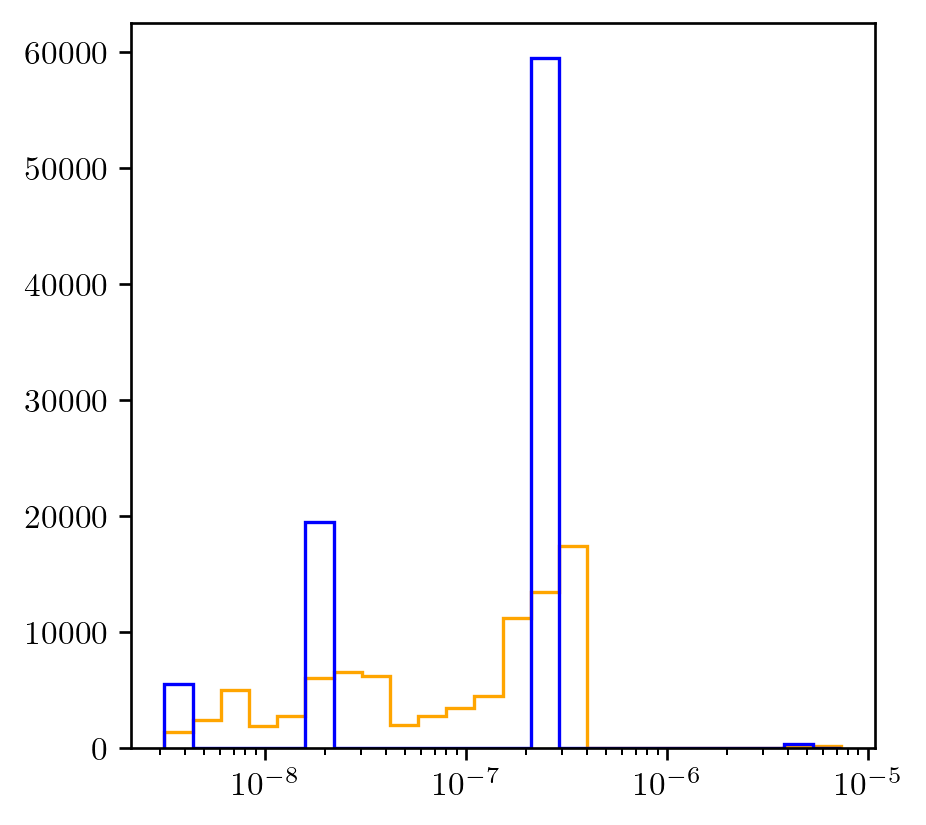

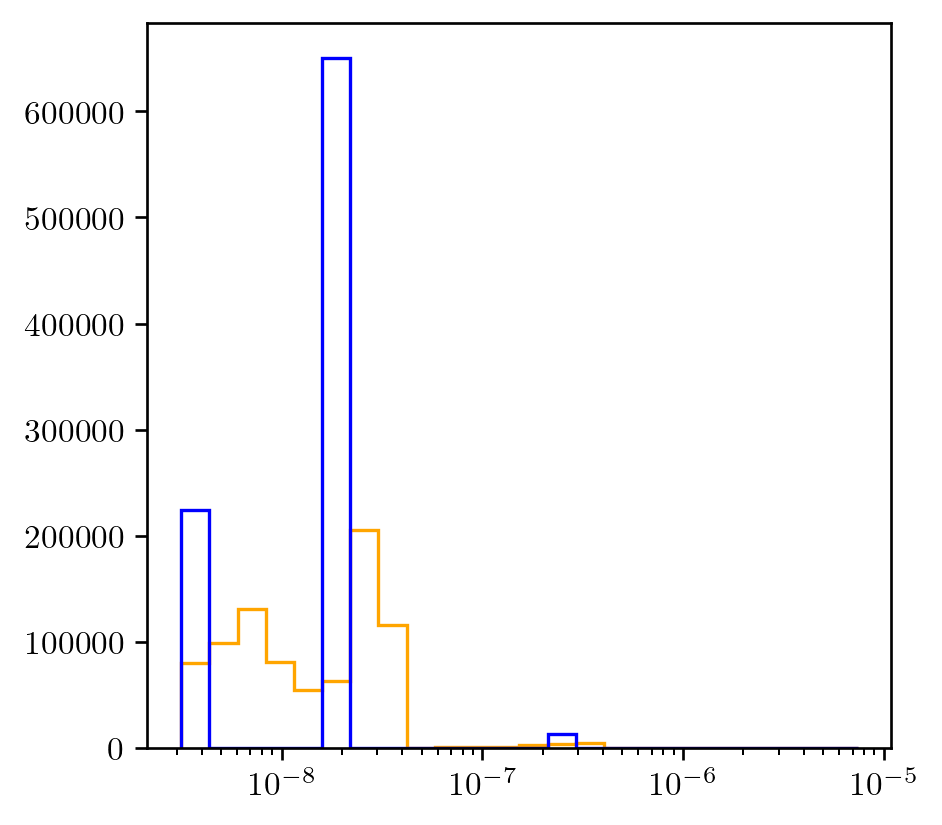

In [4]:
for ptrange,ds in dsets.items():
    sim, gen = ds['sim'], ds['gen']
    
    sim_weights = sim.weights*utils.sim_factors(sim.corr_jet_pts, sim.npvs)
    gen_weights = gen.weights*utils.gen_factors(gen.jet_pts)
    
    bins = 10**np.linspace(-8.5, np.log10(max([max(sim_weights), max(gen_weights)])), 25)
    plt.hist(sim_weights, bins=bins, histtype='step', color='orange')
    plt.hist(gen_weights, bins=bins, histtype='step', color='blue')
    plt.xscale('log')
    plt.show()

In [78]:
#boundaries = {
#    ptranges[0]: {
#        'sim': [0., 1*10**-7, 4.285*10**-7, 1],
#        'gen': [0., 1*10**-7, 3.57*10**-7, 1],
#    },
    
#    ptranges[1]: {
#        'sim': [0., 4.175*10**-7, 1],
#        'gen': [0., 4.15*10**-7, 1],
#    },
#}

boundaries = {
    ptranges[0]: {
        'sim': [0., 2.775*10**-6, 1],
        'gen': [0., 2.825*10**-6, 1],
    },
    
    ptranges[1]: {
        'sim': [0., 3.35*10**-6, 1],
        'gen': [0., 3.35*10**-6, 1],
    },
}

In [86]:
for ptrange,ds in dsets.items():
    if ptrange not in ptranges[1:]:
        continue
        
    print(ptrange)
    
    sim, gen = ds['sim'], ds['gen']
    
    sim_weights = sim.weights * utils.sim_factors(sim.corr_jet_pts, sim.npvs)
    gen_weights = gen.weights * utils.gen_factors(gen.jet_pts)
    
    sim_bounds = boundaries[ptrange]['sim']
    gen_bounds = boundaries[ptrange]['gen']
    
    sim_assigned_weights, gen_assigned_weights = sim_bounds[1:], gen_bounds[1:]
    sim_assigned_weights[-1] = 'guarantee'
    gen_assigned_weights[-1] = 'guarantee'
    
    print('  SIM jets:', len(sim_weights))
    sim_inds, sim_sub_weights, sim_counts = subsample_weights(sim_weights, sim_bounds, sim_assigned_weights)
    print('  SIM jets after subsampling:', len(sim_inds))
    
    ds['sim_inds'] = sim_inds
    ds['sim_sub_weights'] = sim_sub_weights
    
    sim_wt, sim_swt = sim_weights.sum(), sim_sub_weights.sum()
    print('  SIM difference in total weight: {:.3f}%'.format(200*(sim_swt - sim_wt)/(sim_swt + sim_wt)))
    print('  SIM counts:', sim_counts)
    print()
    
    print('  GEN jets:', len(gen_weights))
    gen_inds, gen_sub_weights, gen_counts = subsample_weights(gen_weights, gen_bounds, gen_assigned_weights)
    print('  GEN jets after subsampling:', len(gen_inds))
    
    ds['gen_inds'] = gen_inds
    ds['gen_sub_weights'] = gen_sub_weights
    
    gen_wt, gen_swt = gen_weights.sum(), gen_sub_weights.sum()
    print('  GEN difference in total weight: {:.3f}%'.format(200*(gen_swt - gen_wt)/(gen_swt + gen_wt)))
    print('  GEN counts:', gen_counts)
    print()

(425, 700)
  SIM jets: 1014253
  SIM jets after subsampling: 4975
  SIM difference in total weight: -0.509%
  SIM counts: [4962   13]

  GEN jets: 929053
  GEN jets after subsampling: 5020
  GEN difference in total weight: 0.410%
  GEN counts: [5000   20]



## Save

In [88]:
dsets

{(375, 425): {'sim': <energyflow.datasets.mod.MODDataset at 0x7efd7e675ba8>,
  'gen': <energyflow.datasets.mod.MODDataset at 0x7efd7e675fd0>,
  'sim_specs': [(399, '<= corr_jet_pt <', 401),
   ('abs_jet_eta <', 1.9),
   ('quality >=', 2)],
  'gen_specs': [(399, '<= jet_pt <', 401), ('abs_jet_eta <', 1.9)],
  'sim_inds': array([  0,   2,  23, ..., 380, 381, 382]),
  'sim_sub_weights': array([2.77500000e-06, 2.77500000e-06, 2.77500000e-06, ...,
         4.10792902e-06, 6.47995265e-06, 5.77275616e-06]),
  'gen_inds': array([375, 380, 388, ..., 365, 366, 367]),
  'gen_sub_weights': array([2.82500000e-06, 2.82500000e-06, 2.82500000e-06, ...,
         4.43829098e-06, 4.43851748e-06, 4.43757651e-06])},
 (425, 700): {'sim': <energyflow.datasets.mod.MODDataset at 0x7efd7e67cc50>,
  'gen': <energyflow.datasets.mod.MODDataset at 0x7efd7e67cb38>,
  'sim_specs': [(540, '<= corr_jet_pt <', 560),
   ('abs_jet_eta <', 1.9),
   ('quality >=', 2)],
  'gen_specs': [(540, '<= jet_pt <', 560), ('abs_jet_et

In [89]:
for ds in dsets.values():
    del ds['sim'], ds['gen']
    
with open(utils.path('sim', 'emds', 'SubsampleWeightsInds_5k.pickle'), 'wb') as f:
    pickle.dump(dsets, f)

## Cross Check

In [12]:
weights = sim.weights*utils.sim_factors(sim.corr_jet_pts, sim.npvs)

In [13]:
boundaries = [0., 3*10**-7, 3.25*10**-7, 4*10**-7, 1]
assigned_weights = [3*10**-7, 3.25*10**-7, 4*10**-7, 'guarantee']
#boundaries = [0., 5*10**-5, 1]
#assigned_weights = [5*10**-5, 'guarantee']
print(len(weights), 'jets total')
inds, sub_weights, counts = subsample_weights(weights, boundaries, assigned_weights)
print(len(inds), 'jets selected')
wt, swt = weights.sum(), sub_weights.sum()
print('{:.3f}% difference in total weight'.format(200*(swt - wt)/(swt + wt)))
print(counts)

92328 jets total
40266 jets selected
0.203% difference in total weight
[24271  6104  9517   374]


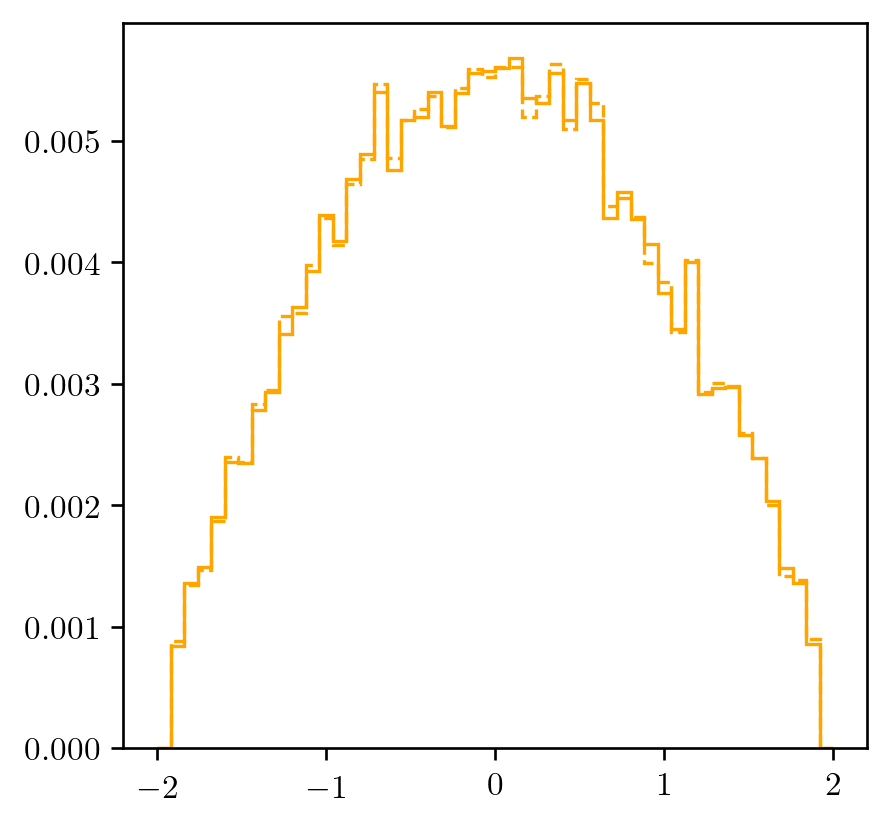

In [16]:
bins = np.linspace(-2, 2, 51)
step = bins[1] - bins[0]
plt.hist(sim.jet_etas, bins=bins, weights=weights/step, histtype='step', color='orange')
plt.hist(sim.jet_etas[inds], bins=bins, weights=sub_weights/step, histtype='step', ls='--', color='orange')
plt.show()